## Cleaning Data (API Called) 6950 data points

In [1]:
#import visualization tools for subsequent analysis
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

df = pd.read_csv('movieDB_API_movies.csv') # read in original csv
df = df.drop(columns='Unnamed: 0') # drop useless column index-like column

# We have many rows with no budget or revenue. We want to filter them out and create a new 'Profit' column
df['gross_profit'] = df[(df['revenue'] != 0) & (df['budget'] != 0)]['revenue'] -df[(df['revenue'] != 0) & (df['budget'] != 0)]['budget']

# Create profit margin column , ROI, with complete dataframe
df['ROI (%)'] = (df['gross_profit'] / df['budget']) * 100

# there are 2677 with null gross_profit
df_profits = df[df['gross_profit'].notna()]

# pd.DataFrame(df).to_csv('movieDB_API_movies_w_gross_profits_&_ROI.csv') #Turn into csv file for easy access

In [2]:
df.head() # this is what our data looks like

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit
0,13200000,"['Comedy', 'Drama', 'Romance']",19404,tt0112870,17.437,1995-10-20,100000000,190.0,Dilwale Dulhania Le Jayenge,8.8,2214,86800000.0
1,25000000,"['Drama', 'Crime']",278,tt0111161,35.028,1994-09-23,28341469,142.0,The Shawshank Redemption,8.7,15045,3341469.0
2,6000000,"['Drama', 'Crime']",238,tt0068646,29.433,1972-03-14,245066411,175.0,The Godfather,8.7,11486,239066411.0
3,11363000,"['Comedy', 'Thriller', 'Drama']",496243,tt6751668,176.819,2019-05-30,201055038,132.0,Parasite,8.6,4751,189692038.0
4,22000000,"['Drama', 'History', 'War']",424,tt0108052,19.641,1993-11-30,321365567,195.0,Schindler's List,8.6,9163,299365567.0


In [3]:
df.info() # 6950 no missing data apparently, 4273/6950 have gross_profit (61% of data can use profit metric)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6950 entries, 0 to 6949
Data columns (total 12 columns):
budget          6950 non-null int64
genres          6950 non-null object
id              6950 non-null int64
imdb_id         6949 non-null object
popularity      6950 non-null float64
release_date    6950 non-null object
revenue         6950 non-null int64
runtime         6937 non-null float64
title           6950 non-null object
vote_average    6950 non-null float64
vote_count      6950 non-null int64
gross_profit    4273 non-null float64
dtypes: float64(4), int64(4), object(4)
memory usage: 651.6+ KB


In [4]:
df[df['budget']==0]

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit
6,0,"['Romance', 'Animation', 'Drama']",372058,tt5311514,29.292,2016-08-26,357986087,106.0,Your Name.,8.5,5018,NaN
17,0,"['Adventure', 'Comedy']",40096,tt0271383,9.056,2000-09-15,0,104.0,A Dog's Will,8.4,568,NaN
24,0,"['Drama', 'Romance']",11216,tt0095765,14.666,1988-11-17,11990401,124.0,Cinema Paradiso,8.4,2077,NaN
26,0,"['Comedy', 'Drama']",579245,tt8655470,24.981,2019-10-23,0,114.0,The Specials,8.4,216,NaN
31,0,"['Drama', 'Science Fiction', 'Animation']",18491,tt0169858,12.520,1997-07-19,20000000,87.0,Neon Genesis Evangelion: The End of Evangelion,8.4,483,NaN
34,0,"['Drama', 'Mystery']",432517,tt3845892,8.352,2017-01-15,0,90.0,Sherlock: The Final Problem,8.4,764,NaN
36,0,['Drama'],3782,tt0044741,11.395,1952-10-09,55240,143.0,Ikiru,8.4,459,NaN
38,0,['Drama'],18148,tt0046438,10.696,1953-11-03,0,134.0,Tokyo Story,8.4,431,NaN
40,0,"['Drama', 'Romance']",11659,tt0346336,8.599,2003-06-22,2693053,366.0,The Best of Youth,8.4,261,NaN
41,0,"['Animation', 'Family', 'Adventure', 'Comedy']",508965,tt4729430,26.087,2019-11-08,0,96.0,Klaus,8.3,1401,NaN


## What do we do with rows with missing gross profits?

#### Create subset of data points with gross profit. We have 4273/6950 data points that have a calculated gross profit. We will analyze our data to learn more about and see if there's other data we need. We won't remove the 0 values but we won't use them now.

In [5]:
df = df[df['gross_profit'].notna()]

In [6]:
# Create profit margin column , investment, ROI
df['ROI (%)'] = (df['gross_profit'] / df['budget']) * 100
df.head()

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit,ROI (%)
0,13200000,"['Comedy', 'Drama', 'Romance']",19404,tt0112870,17.437,1995-10-20,100000000,190.0,Dilwale Dulhania Le Jayenge,8.8,2214,86800000.0,657.575758
1,25000000,"['Drama', 'Crime']",278,tt0111161,35.028,1994-09-23,28341469,142.0,The Shawshank Redemption,8.7,15045,3341469.0,13.365876
2,6000000,"['Drama', 'Crime']",238,tt0068646,29.433,1972-03-14,245066411,175.0,The Godfather,8.7,11486,239066411.0,3984.440183
3,11363000,"['Comedy', 'Thriller', 'Drama']",496243,tt6751668,176.819,2019-05-30,201055038,132.0,Parasite,8.6,4751,189692038.0,1669.383420
4,22000000,"['Drama', 'History', 'War']",424,tt0108052,19.641,1993-11-30,321365567,195.0,Schindler's List,8.6,9163,299365567.0,1360.752577


## What are the genres?

In [7]:
# What genres do we have?
## 1625 unique combinations of genres

# Top 3 Genres?
## Comedy 552/1625 or 34%
## Drama 419/1625 or 26%
## (Drama + Romance) 195/1625 or 12%
1
#showing first ten genres
df['genres'].value_counts()[0:10] #we should keep the combinations... They're important

['Comedy']                        237
['Drama']                         234
['Drama', 'Romance']              114
['Comedy', 'Romance']             106
['Horror', 'Thriller']             91
['Comedy', 'Drama']                85
['Comedy', 'Drama', 'Romance']     79
['Horror']                         69
['Drama', 'Thriller']              52
['Action', 'Thriller']             45
Name: genres, dtype: int64

## What's the distribution of movie popularity?

In [8]:
df.head()

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit,ROI (%)
0,13200000,"['Comedy', 'Drama', 'Romance']",19404,tt0112870,17.437,1995-10-20,100000000,190.0,Dilwale Dulhania Le Jayenge,8.8,2214,86800000.0,657.575758
1,25000000,"['Drama', 'Crime']",278,tt0111161,35.028,1994-09-23,28341469,142.0,The Shawshank Redemption,8.7,15045,3341469.0,13.365876
2,6000000,"['Drama', 'Crime']",238,tt0068646,29.433,1972-03-14,245066411,175.0,The Godfather,8.7,11486,239066411.0,3984.440183
3,11363000,"['Comedy', 'Thriller', 'Drama']",496243,tt6751668,176.819,2019-05-30,201055038,132.0,Parasite,8.6,4751,189692038.0,1669.383420
4,22000000,"['Drama', 'History', 'War']",424,tt0108052,19.641,1993-11-30,321365567,195.0,Schindler's List,8.6,9163,299365567.0,1360.752577


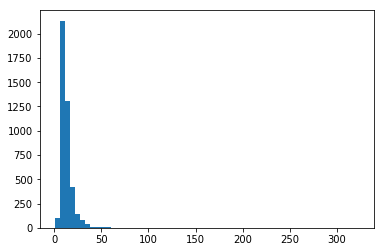

In [9]:
plt.hist(df[df['popularity'] > 0]['popularity'], bins=60);
plt.show()

## What's the range of average vote ratings?

/Users/chrischung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    4273.000000
mean        6.540417
std         0.832336
min         2.600000
25%         6.000000
50%         6.500000
75%         7.100000
max         8.800000
Name: vote_average, dtype: float64

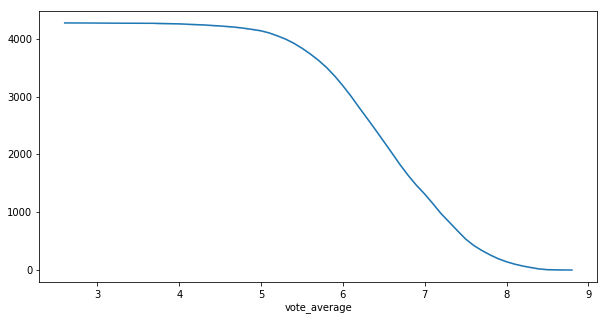

In [10]:
y = range(0, df['title'].count()) # plotting movie vote_average
x = df['vote_average']
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x,y);

x.describe() 

It looks like most of our data is under 7

In [11]:
df.head()

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit,ROI (%)
0,13200000,"['Comedy', 'Drama', 'Romance']",19404,tt0112870,17.437,1995-10-20,100000000,190.0,Dilwale Dulhania Le Jayenge,8.8,2214,86800000.0,657.575758
1,25000000,"['Drama', 'Crime']",278,tt0111161,35.028,1994-09-23,28341469,142.0,The Shawshank Redemption,8.7,15045,3341469.0,13.365876
2,6000000,"['Drama', 'Crime']",238,tt0068646,29.433,1972-03-14,245066411,175.0,The Godfather,8.7,11486,239066411.0,3984.440183
3,11363000,"['Comedy', 'Thriller', 'Drama']",496243,tt6751668,176.819,2019-05-30,201055038,132.0,Parasite,8.6,4751,189692038.0,1669.383420
4,22000000,"['Drama', 'History', 'War']",424,tt0108052,19.641,1993-11-30,321365567,195.0,Schindler's List,8.6,9163,299365567.0,1360.752577


## Plotting gross profit vs vote average

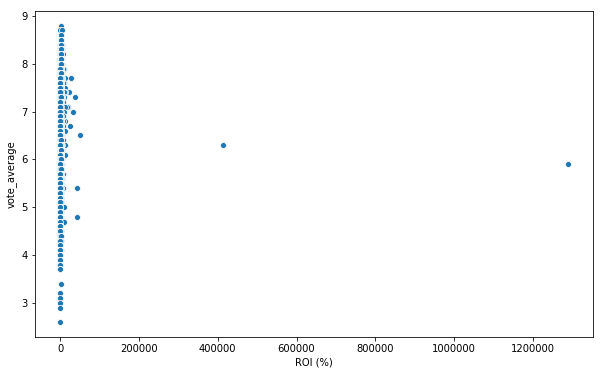

In [114]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(df['ROI (%)'], df['vote_average']);

# the majority of movies making money have an average rating 5.5 - 8.5 (estimated)

## Plotting gross profit vs vote count

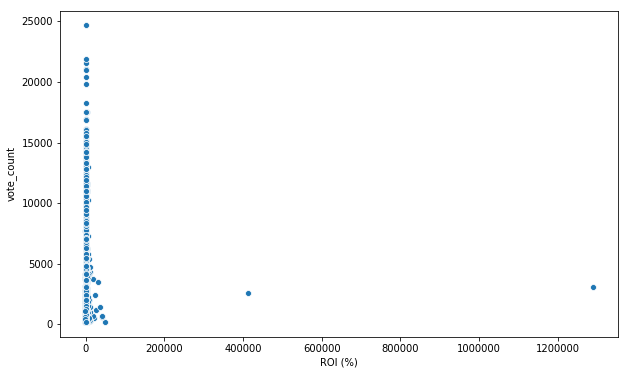

In [115]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(df['ROI (%)'], df['vote_count'])

# there is positive correlation between gross_profit and vote_count
# more vote counts more money

## Plotting gross profit vs popularity

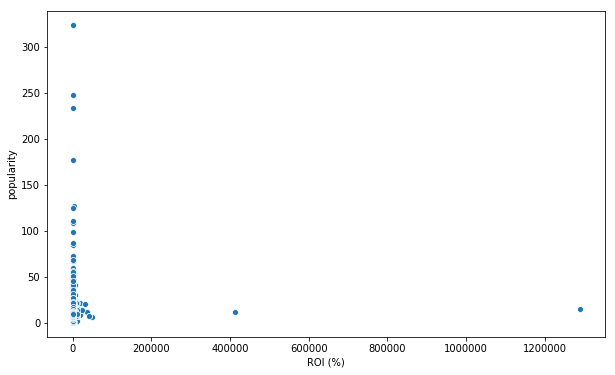

In [116]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(df['ROI (%)'], df['popularity'])

#isn't much correlation 

In [84]:
df['genres'][0].split()

["['Comedy',", "'Drama',", "'Romance']"]

In [85]:
genre_count_list = []
pd.DataFrame(df['genres']).iloc[0]
# so far each entry is made up of strings

df['genres'].value_counts() # maybe we can see for each genres 

['Comedy']                                                                     237
['Drama']                                                                      234
['Drama', 'Romance']                                                           114
['Comedy', 'Romance']                                                          106
['Horror', 'Thriller']                                                          91
['Comedy', 'Drama']                                                             85
['Comedy', 'Drama', 'Romance']                                                  79
['Horror']                                                                      69
['Drama', 'Thriller']                                                           52
['Action', 'Thriller']                                                          45
['Drama', 'History']                                                            44
['Crime', 'Drama', 'Thriller']                                                  41
['Dr

In [86]:
df[df['gross_profit'] > 1000000000]['genres'].value_counts()

['Action', 'Adventure', 'Science Fiction']                3
['Action', 'Adventure', 'Fantasy', 'Science Fiction']     2
['Adventure', 'Action', 'Science Fiction']                1
['Fantasy', 'Adventure', 'Science Fiction', 'Action']     1
['Fantasy', 'Adventure']                                  1
['Drama', 'Romance', 'Thriller']                          1
['Family', 'Fantasy', 'Romance']                          1
['Action', 'Thriller']                                    1
['Science Fiction', 'Action', 'Adventure']                1
['Animation', 'Family', 'Adventure']                      1
['Adventure', 'Family']                                   1
['Action', 'Adventure', 'Science Fiction', 'Thriller']    1
['Family', 'Animation', 'Adventure', 'Comedy']            1
['Adventure', 'Science Fiction', 'Action']                1
['Crime', 'Thriller', 'Drama']                            1
['Action', 'Adventure', 'Science Fiction', 'Fantasy']     1
['Adventure', 'Fantasy', 'Action']      